In [1]:
from sklearn.datasets import fetch_20newsgroups
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import random
import numpy as np
import seaborn as sn
import pandas as pd

random.seed(3116)

Exercise 0: Preprocessing Text Data

In [2]:
#Download stopwords and puctuation
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
#Get data from specific categories
cats = ['sci.med', 'comp.graphics']
newsgroups = fetch_20newsgroups(categories=cats)
data=newsgroups['data']

In [4]:
#Remove stop words
stop_words = set(stopwords.words('english'))

map_stopwords = map(word_tokenize, data)
clean_data = list(map_stopwords)

map_join = map(' '.join, clean_data)
clean_data = list(map_join)

In [5]:
#Remove punctuation
tokenizer = RegexpTokenizer(r'\w+')

map_puntuation = map(tokenizer.tokenize, clean_data)
clean_data = list(map_puntuation)

map_join = map(' '.join, clean_data)
clean_data = list(map_join)

In [6]:
#Extract bags of words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [7]:
count_vect = CountVectorizer()
counts = count_vect.fit_transform(clean_data)

In [8]:
#TF-IDF feature representation
from sklearn.feature_extraction.text import TfidfTransformer

In [9]:
tfidf_transformer = TfidfTransformer()
data_tfidf = tfidf_transformer.fit_transform(counts)

In [10]:
#Split data into train, validation and test
order=np.arange(len(data))
random.shuffle(order)

y_train=newsgroups['target'][order[:round(len(order)*0.8)]]
y_valid=newsgroups['target'][order[round(len(order)*0.8):round(len(order)*0.9)]]
y_test=newsgroups['target'][order[round(len(order)*0.9):]]

bag_train=counts[order[:round(len(order)*0.8)]]
bag_valid=counts[order[round(len(order)*0.8):round(len(order)*0.9)]]
bag_test=counts[order[round(len(order)*0.9):]]
                
tfidf_train=data_tfidf[order[:round(len(order)*0.8)]]
tfidf_valid=data_tfidf[order[round(len(order)*0.8):round(len(order)*0.9)]]
tfidf_test=data_tfidf[order[round(len(order)*0.9):]]

Exercise 1: Implementing Naive Bayes Classifier for Text Data 

In [11]:
#Train and validate the Naive Bayes Classifier 

In [12]:
def train_naive_bayes(x_train, y_train, alpha):
  n=x_train.shape[0]
  probabilities=(x_train.sum(axis=0)+alpha) #Get probabilities for words
  group_labels=np.unique(y_train) #Get group labels

  probabilities_for_elements=[]
  probability_of_group=[]

  for group in group_labels:
    group_probability=np.array(x_train[y_train==group].sum(axis=0)+alpha) #Probability of word in group
    n_group=np.sum((y_train==group)*1) #Prior probability

    #Store variables
    probabilities_for_elements.append(group_probability/n_group)
    probability_of_group.append(n_group/n)

  return group_labels, probability_of_group, probabilities_for_elements

In [13]:
def predict_naive_bayes(x, probability_of_groups, probability_of_elements):
  results=probability_of_elements**np.array(bag_test.todense()) #Probabilitiess are elevated to the number of times they appear in x
  probabilities_of_classification=[]
  
  for i in range(len(probability_of_groups)):
    multiplication=np.prod(results[i],axis=1) #Multiply the probabilities for all elements
    multiplication*=probability_of_groups[i] #Multiply by prior

    probabilities_of_classification.append(multiplication) #Save probability

  classification=np.argmax(probabilities_of_classification,axis=0) #Classify as highest probability
  return classification

In [14]:
#Create confusion matrix
def evaluate_classification(y,y_hat):
  should_be_0_y=y[y==0]
  should_be_0_y_hat=y_hat[y==0]
  should_be_1_y=y[y==1]
  should_be_1_y_hat=y_hat[y==1]
  
  p1=np.sum((should_be_0_y==should_be_0_y_hat)*1)
  p2=np.sum((should_be_0_y!=should_be_0_y_hat)*1)
  p3=np.sum((should_be_1_y==should_be_1_y_hat)*1)
  p4=np.sum((should_be_1_y!=should_be_1_y_hat)*1)

  return [[p1, p2],[p4, p3]]


In [15]:
#Calculate accuracy
def accuracy(y,y_hat):
  return np.sum((y==y_hat)*1)/len(y)

In [16]:
#Train, predict and evaluate bag of words
g_bag, pg_bag, pe_bag=train_naive_bayes(bag_train, y_train, 0.01)
predictions_bag=predict_naive_bayes(bag_test, pg_bag, pe_bag)
cm_bag=evaluate_classification(y_test,predictions_bag)

print(f'The accuracy for bag of words was {accuracy(predictions_bag,y_test)}')


The accuracy for bag of words was 0.923728813559322


In [17]:
#Train, predict and evaluate TF-IDF
g_tfidf, pg_tfidf, pe_tfidf=train_naive_bayes(tfidf_train, y_train, 0.01)
predictions_tfidf=predict_naive_bayes(tfidf_test, pg_tfidf, pe_tfidf)
cm_tfidf=evaluate_classification(y_test,predictions_tfidf)

print(f'The accuracy for TF-IDF was {accuracy(predictions_tfidf,y_test)}')

The accuracy for TF-IDF was 0.7033898305084746


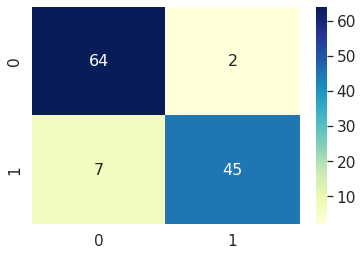

In [18]:
#Plot confusion matrix for bag of words
df_cm = pd.DataFrame(cm_bag, range(2), range(2))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='YlGnBu') # font size

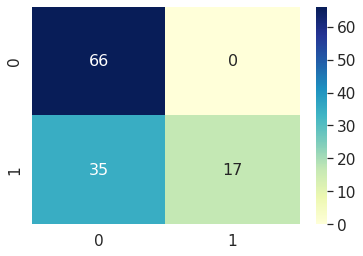

In [19]:
#Plot confusion matrix for TF-IDF
df_cm = pd.DataFrame(cm_tfidf, range(2), range(2))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='YlGnBu') # font size

Exercise 2: Implementing SVM Classifier via Scikit-Learn

In [20]:
#Tune the different SVM kernel choices provided by Scikit-Learn, and other associated hyperparameters for validation set
from sklearn import svm

In [21]:
#Create array of possible parameters
params={'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 
        'C': np.logspace(-2, 10, 13), 
        'gamma': np.logspace(-9, 3, 13), 
        'degree': [2,3,5]}

In [22]:
#Evauate different parameters on validation set and choose the best ones
max_iter=30
accuracies=[]
parameters=[]

for i in range(max_iter):
  k,c,g,d = params['kernel'][np.random.randint(len(params['kernel']))],params['C'][np.random.randint(len(params['C']))],params['gamma'][np.random.randint(len(params['gamma']))],params['degree'][np.random.randint(len(params['degree']))]
  parameters.append([k,c,g,d])
  clf = svm.SVC(kernel=k,C=c,gamma=g,degree=d)
  clf.fit(bag_train, y_train)
  predictions=clf.predict(bag_valid)
  accuracies.append(accuracy(np.array(y_valid),np.array(predictions)))

print(f'Best accuracy for bag of words was {np.max(np.array(accuracies))} with parameters {parameters[np.argmax(np.array(accuracies))]}')


Best accuracy for bag of words was 0.9915254237288136 with parameters ['linear', 0.1, 1000.0, 2]


In [23]:
#Report the test-set accuracy
params=parameters[np.argmax(np.array(accuracies))]
clf = svm.SVC(kernel=params[0],C=params[1],gamma=params[2],degree=params[3])
clf.fit(bag_train, y_train)
predictions=clf.predict(bag_test)

print(f'The test accuracy was {accuracy(np.array(y_test),np.array(predictions))}')

The test accuracy was 0.9661016949152542


In [24]:
#Create array of possible parameters
params={'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 
        'C': np.logspace(-2, 10, 13), 
        'gamma': np.logspace(-9, 3, 13), 
        'degree': [2,3,5]}

In [25]:
#Evauate different parameters on validation set and choose the best ones
max_iter=30
accuracies=[]
parameters=[]

for i in range(max_iter):
  k,c,g,d = params['kernel'][np.random.randint(len(params['kernel']))],params['C'][np.random.randint(len(params['C']))],params['gamma'][np.random.randint(len(params['gamma']))],params['degree'][np.random.randint(len(params['degree']))]
  parameters.append([k,c,g,d])
  clf = svm.SVC(kernel=k,C=c,gamma=g,degree=d)
  clf.fit(tfidf_train, y_train)
  predictions=clf.predict(tfidf_valid)
  accuracies.append(accuracy(np.array(y_valid),np.array(predictions)))

print(f'best accuracy for TF-IDF was {np.max(np.array(accuracies))} with parameters {parameters[np.argmax(np.array(accuracies))]}')

best accuracy for TF-IDF was 0.9830508474576272 with parameters ['linear', 10000.0, 1e-09, 5]


In [26]:
#Report the test-set accuracy
params=parameters[np.argmax(np.array(accuracies))]
clf = svm.SVC(kernel=params[0],C=params[1],gamma=params[2],degree=params[3])
clf.fit(tfidf_train, y_train)
predictions=clf.predict(tfidf_test)

print(f'The test accuracy was {accuracy(np.array(y_test),np.array(predictions))}')

The test accuracy was 0.9915254237288136
